In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import pickle
import normalize_data
import random
import train

pd.set_option('display.max_columns', 999)
pd.set_option('display.precision', 10)

In [2]:
def get_ref_X_y(df):
    ref_cols = [c for c in df.columns if c.startswith('__')]
    X_cols = [c for c in df.columns if c.startswith('X_')]
    y_cols = [c for c in df.columns if c.startswith('y_')]
    return (df[ref_cols], df[X_cols], df[y_cols])

In [3]:
raw_data = {} # loads raw data and stores as a dict cache

def dataset_key(dataset='', validation=False):
    return dataset+('test' if validation else 'train')


def load_data(raw, dataset='', validation=False):
    '''
    Return dataframe matching data set and validation. Dictionary input will be updated.

    Parameters
    ----------
    raw : dict
        dictionary which caches the dataframes and will be updated accordingly

    dataset : str
        which dataset to use? valid input includes: empty str for full set, sample_, and secret_

    validation : bool
        load validation set? if true then use _test, otherwise use _train.  Note secret_ doesn't have _train
    '''
    key = dataset+('test' if validation else 'train')
    if key not in raw:
        print(f"Loading data to cache for: {key}")
        raw[key] = pd.read_pickle(f'{os.environ["GP_HIST_PATH"]}/../t4_data/{key}.pkl')
    return raw[key]

In [4]:
configurations = {
    'dataset' : 'sample_', # '', 'sample_', 'secret_'
    'model_identifier' : "all_small_2",
    'model_path' : f"{os.environ['GP_HIST_PATH']}/../t4_models",
    'train_params' : {
        'batch_size': 50000,
        'shuffle': True,
        'num_workers': 3,
        'pin_memory': True,
    },
    'test_params' : {
        'batch_size': 200000,
        'num_workers': 2,
        'pin_memory': True,
    },
}

In [5]:
%%time

train_df = normalize_data.normalize_all_columns(load_data(raw_data,dataset=configurations['dataset'],validation=False))
test_df = normalize_data.normalize_all_columns(load_data(raw_data,dataset=configurations['dataset'],validation=True))

train_df = train_df.dropna()
test_df = test_df.dropna()
# train_df = train_df.sample(100000, random_state=42)
# test_df = test_df.sample(10000, random_state=42)

Loading data to cache for: sample_train
Loading data to cache for: sample_test
CPU times: user 735 ms, sys: 640 ms, total: 1.38 s
Wall time: 1.09 s


In [6]:
ref_train, X_train, y_train = get_ref_X_y(train_df)
ref_test, X_test, y_test = get_ref_X_y(test_df)

In [7]:
y_cols = ['y_INCLINATION', 'y_ECCENTRICITY', 'y_MEAN_MOTION', 'y_RA_OF_ASC_NODE_REG', 'y_RA_OF_ASC_NODE', 'y_ARG_OF_PERICENTER_REG', 'y_ARG_OF_PERICENTER', 'y_BSTAR', 'y_REV_MA_REG', 'y_MEAN_ANOMALY']
y_cols = ['y_INCLINATION', 'y_ECCENTRICITY', 'y_MEAN_MOTION', 'y_RA_OF_ASC_NODE_REG', 'y_ARG_OF_PERICENTER_REG', 'y_REV_MA_REG']
# y_cols = ['y_REV_MA_REG']
y_train = y_train[y_cols]
y_test = y_test[y_cols]

# y_train = np.sign(y_train) * np.log(1+np.abs(y_train))
# y_test = np.sign(y_test) * np.log(1+np.abs(y_test))

In [8]:
# model, mean_losses = train.train_model(X_train, y_train, X_test, y_test, configurations, force_train=False)

Loading existing model


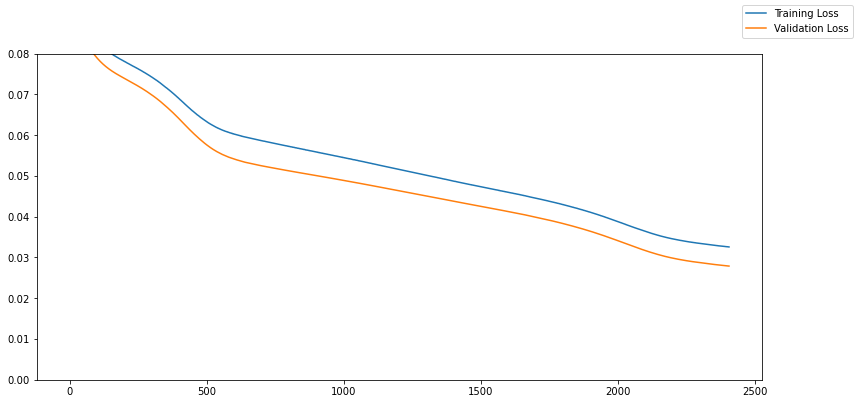

In [45]:
model, _, _, mean_losses, _ = train.load_model_with_config(configurations)

tl, vl = zip(*mean_losses)

fig,ax = plt.subplots(figsize=(13,6))
ax.plot(tl, label="Training Loss")
ax.plot(vl, label="Validation Loss")
plt.ylim(0, 0.08)
fig.legend()
plt.show()

In [39]:
trained_model = model
sample_idx = random.sample(list(X_test.index), 10000)

X_sample = X_test.loc[sample_idx]
y_sample = y_test.loc[sample_idx]
# y_train_pred = train.predict(trained_model, X_train, y_train, device="cpu") # get predictions for each train
# y_train_pred_df = pd.DataFrame(y_train_pred, columns=y_train.columns)  # put results into a dataframe
y_sample_pred = train.predict(trained_model, X_sample, y_sample, device="cpu") # get predictions for each train
y_sample_pred_df = pd.DataFrame(y_sample_pred, columns=y_sample.columns, index=y_sample.index)  # put results into a dataframe

In [40]:
print(f'    Test set MAE (L1) loss: {mean_absolute_error(y_sample, y_sample_pred_df)}')
print(f'    Test set MSE (L2) loss: {mean_squared_error(y_sample, y_sample_pred_df)}')

# random.seed(342798)
sample = random.sample(list(y_sample_pred_df.index), 10)
# sample = [0,1]

print("Test - Ground Truth (normalized):")
display(y_sample)
print("Test - Prediction (normalized):")
display(y_sample_pred_df)
# print("Ground Truth Diffs from X_:")
# display(y_sample - X_sample[['X_INCLINATION_1','X_ECCENTRICITY_1','X_MEAN_MOTION_1']].values)
# print("Pred Diffs from X_:")
# display(y_sample_pred_df - X_sample[['X_INCLINATION_1','X_ECCENTRICITY_1','X_MEAN_MOTION_1']].values)


    Test set MAE (L1) loss: 0.09415147200750855
    Test set MSE (L2) loss: 0.028495288053955136
Test - Ground Truth (normalized):


,y_INCLINATION,y_ECCENTRICITY,y_MEAN_MOTION,y_RA_OF_ASC_NODE_REG,y_ARG_OF_PERICENTER_REG,y_REV_MA_REG
58537,0.5485811111,0.0399424,0.3392386926,0.0735902778,0.7423741667,0.3250531049
40789,0.1612377778,0.0616652,0.4360305886,0.7709811111,0.3578166667,1.1516224753
351,0.3691811111,0.2216064,0.2641524251,0.8968966667,0.8926388889,0.3344099568
64388,0.5485338889,0.0399788,0.3392303554,0.7665544444,0.6359091667,0.8706890216
68774,0.5481700000,0.0403544,0.3401323703,0.6151222222,0.2207425000,0.8864748519
...,...,...,...,...,...,...
14269,0.3690505556,0.1050560,0.3605118869,0.8867322222,0.9594633333,0.3226529259
22665,0.3692038889,0.1384988,0.3309103806,0.0613225000,0.5989486111,0.6154978549
13681,0.3691166667,0.1271356,0.3415460926,0.3617144444,0.8667425000,0.6347350463
51797,0.5503227778,0.0718836,0.3590488080,0.2193136111,0.4051205556,1.0399830000


Test - Prediction (normalized):


,y_INCLINATION,y_ECCENTRICITY,y_MEAN_MOTION,y_RA_OF_ASC_NODE_REG,y_ARG_OF_PERICENTER_REG,y_REV_MA_REG
58537,0.5464910269,-0.0145969912,0.3602473736,0.3613954484,0.3618980944,0.5694942474
40789,0.1625163406,0.0641280115,0.4206371307,0.9633926749,0.3845734000,1.1651381254
351,0.3647586107,0.1764092892,0.2803221345,0.7463143468,1.0767147541,0.4245730937
64388,0.5440392494,0.0500591882,0.3364586532,0.7854401469,0.5251195431,0.6446527243
68774,0.5479260683,0.0477968454,0.3405840993,0.5563856363,0.2272179127,1.0608377457
...,...,...,...,...,...,...
14269,0.3656521142,0.0527503230,0.3800153732,0.7779254913,1.0218498707,0.3648096323
22665,0.3636894822,0.1107387245,0.3390548825,0.1364519298,0.3829606771,0.7160059214
13681,0.3618479073,0.1141710654,0.3533086479,0.3959259093,0.7902973890,0.4467269778
51797,0.5455145836,0.0814701095,0.3556884527,0.1385124922,0.5454142690,0.8664190173
